# Feature Selection

(And some testing for each to choose 'good' hyperparameters)

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [2]:
# cube-root transformation (if needed)
""" var_skewness = df_clean.loc[:,'frame_count':].skew(axis = 0).abs()
o = dict(var_skewness[var_skewness>0.9])
print(len(o))
skewed = list(o.keys())
df_clean[skewed] = np.cbrt(df_clean[skewed])
df_clean.head() """

" var_skewness = df_clean.loc[:,'frame_count':].skew(axis = 0).abs()\no = dict(var_skewness[var_skewness>0.9])\nprint(len(o))\nskewed = list(o.keys())\ndf_clean[skewed] = np.cbrt(df_clean[skewed])\ndf_clean.head() "

### Importing dataset up to Cubic transformation

In [3]:
# dataset with cube-root transformation after having removed only the
# irrelevant features (no correlation analysis, no min-max scaling, no variance threshold,...)
df = pd.read_csv('data/old_csv/data_full_upto_cubicTr.csv') #quello con anche il test set
df_train = df.loc[:1827,:].copy() #solo train set, si lavora su questo per via del bias che si andrebbe a creare
df_train.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,q95,q99,kur,skew,lag1_sum,lag1_mean,lag1_std,lag1_min,lag1_max,lag1_q01,lag1_q05,lag1_q25,lag1_q75,lag1_q95,lag1_q99,lag1_kur,lag1_skew,zc_sum,zc_mean,zc_std,zc_q95,zc_kur,zc_skew,mfcc_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,mfcc_q01,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,mfcc_kur,mfcc_skew,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,sc_skew,stft_sum,stft_mean,stft_std,stft_min,stft_q01,stft_q05,stft_q25,stft_q50,stft_q75,stft_kur,stft_skew,length_w1,sum_w1,mean_w1,std_w1,min_w1,max_w1,q01_w1,q05_w1,q25_w1,q50_w1,q75_w1,q95_w1,q99_w1,kur_w1,skew_w1,lag1_sum_w1,lag1_mean_w1,lag1_std_w1,lag1_min_w1,lag1_max_w1,lag1_q01_w1,lag1_q05_w1,...,mfcc_skew_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,sc_q75_w3,sc_q95_w3,sc_q99_w3,sc_kur_w3,sc_skew_w3,stft_sum_w3,stft_mean_w3,stft_std_w3,stft_min_w3,stft_q01_w3,stft_q05_w3,stft_q25_w3,stft_q50_w3,stft_q75_w3,stft_kur_w3,stft_skew_w3,length_w4,sum_w4,mean_w4,std_w4,min_w4,max_w4,q01_w4,q05_w4,q25_w4,q50_w4,q75_w4,q95_w4,q99_w4,kur_w4,skew_w4,lag1_sum_w4,lag1_mean_w4,lag1_std_w4,lag1_min_w4,lag1_max_w4,lag1_q01_w4,lag1_q05_w4,lag1_q25_w4,lag1_q75_w4,lag1_q95_w4,lag1_q99_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_mean_w4,zc_std_w4,zc_q95_w4,zc_kur_w4,zc_skew_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_min_w4,mfcc_max_w4,mfcc_q01_w4,mfcc_q05_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q75_w4,mfcc_q95_w4,mfcc_q99_w4,mfcc_kur_w4,mfcc_skew_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q01_w4,sc_q05_w4,sc_q25_w4,sc_q50_w4,sc_q75_w4,sc_q95_w4,sc_q99_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_mean_w4,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,M,158558,0.525456,0.009708,0.158749,-0.337436,0.343664,-0.232613,-0.180594,-0.03125,0.0,0.178383,0.248102,2.467774,0.904033,0.000000,0.000000e+00,0.079928,-0.221687,0.263573,-0.117384,-0.080353,0.0,0.0,0.080353,0.119558,3.727413,0.873354,8015,0.050549,0.219076,1.0,2.457186,4.103157,-58.218880,-31.827303,165.355352,-861.532578,236.703871,-861.532578,-103.279677,-2.440220,0.000000,4.410921,30.161469,168.757852,2.574988,-4.202406,2.299052e+06,7416.297748,4428.027507,0.000000,14584.465980,902.565913,1201.423033,2283.332142,9147.820660,11550.242513,12008.514338,23.037355,-1.176257,-0.303929,2355.100189,0.633091,0.280529,0.000000,0.367365,0.479163,0.431064,0.695607,0.863931,-0.947927,-0.529667,39639,-0.145050,-0.004254,0.045313,-0.211041,0.208264,-0.031250,0.00000,0.0,0.0,0.0,0.00000,0.03125,19.832931,2.213239,-0.000031,-7.699071e-10,0.053816,-0.221687,0.263573,-0.03125,0.00000,...,-1.551406,59.344532,2679.461545,13.068764,880.936159,8892.747189,898.619679,1112.369427,1261.981273,11.829897,14.092324,8336.026071,8820.908362,1.128222,1.659956,7.724220,0.492366,0.664761,0.334061,0.376706,0.435976,0.616518,0.457067,0.716272,-1.038043,0.288573,39640,-0.115888,-3.926328e-08,0.023562,-0.049606,0.053437,-0.031250,-0.03125,0.0,0.0,0.0,0.03125,0.031250,2.598756,0.775000,0.000000,0.000000e+00,0.022230,-0.039373,0.039373,-0.03125,-0.03125,0.0,0.0,0.03125,0.03125,1.840304,0.012982,12.932590,0.379293,0.227131,1.0,2.374269,1.577050,-67835.222173,-43.484117,217.850787,-1131.370850,73.740175,-1047.422157,-3.774916,0.114946,3.853755,8.281780,21.986026,48.030010,2.487833,-4.152495,833179.006394,10681.782133,1566.324873,0.000000,22.940280,6157.993552,8928.597851,10439.979745,22.232087,22.597079,22.895031,22.929488,2.929879,-4.175609,740.409892,0.791036,0.155455,0.000000,0.000000,0.566462,0.709962,0.927985,0.964274,1.0,1.889152,-1.706215
1,speech,neutral,normal,Kids are talking by the door,2nd,M,160160,0.485332,0.008937,0.162403,-0.349257,0.363819,-0.238403,-0.182751,-0.03125,0.0,0.180905,0.251456,2.545226,1.001578,0.000000,0.000000

### Dataset normalization

In [4]:
# scaling the whole dataset (TRAIN and TEST)
mmscaler = MinMaxScaler()
cols = df.loc[:,'frame_count':].columns
df[cols] = mmscaler.fit_transform(df[cols])
print(df_train.shape)
df.head()

(1828, 374)


,vocal_channel,emotion,emotional_intensity,statement,repetition,sex,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,q95,q99,kur,skew,lag1_sum,lag1_mean,lag1_std,lag1_min,lag1_max,lag1_q01,lag1_q05,lag1_q25,lag1_q75,lag1_q95,lag1_q99,lag1_kur,lag1_skew,zc_sum,zc_mean,zc_std,zc_q95,zc_kur,zc_skew,mfcc_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,mfcc_q01,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,mfcc_kur,mfcc_skew,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,sc_skew,stft_sum,stft_mean,stft_std,stft_min,stft_q01,stft_q05,stft_q25,stft_q50,stft_q75,stft_kur,stft_skew,length_w1,sum_w1,mean_w1,std_w1,min_w1,max_w1,q01_w1,q05_w1,q25_w1,q50_w1,q75_w1,q95_w1,q99_w1,kur_w1,skew_w1,lag1_sum_w1,lag1_mean_w1,lag1_std_w1,lag1_min_w1,lag1_max_w1,lag1_q01_w1,lag1_q05_w1,...,mfcc_skew_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,sc_q75_w3,sc_q95_w3,sc_q99_w3,sc_kur_w3,sc_skew_w3,stft_sum_w3,stft_mean_w3,stft_std_w3,stft_min_w3,stft_q01_w3,stft_q05_w3,stft_q25_w3,stft_q50_w3,stft_q75_w3,stft_kur_w3,stft_skew_w3,length_w4,sum_w4,mean_w4,std_w4,min_w4,max_w4,q01_w4,q05_w4,q25_w4,q50_w4,q75_w4,q95_w4,q99_w4,kur_w4,skew_w4,lag1_sum_w4,lag1_mean_w4,lag1_std_w4,lag1_min_w4,lag1_max_w4,lag1_q01_w4,lag1_q05_w4,lag1_q25_w4,lag1_q75_w4,lag1_q95_w4,lag1_q99_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_mean_w4,zc_std_w4,zc_q95_w4,zc_kur_w4,zc_skew_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_min_w4,mfcc_max_w4,mfcc_q01_w4,mfcc_q05_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q75_w4,mfcc_q95_w4,mfcc_q99_w4,mfcc_kur_w4,mfcc_skew_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q01_w4,sc_q05_w4,sc_q25_w4,sc_q50_w4,sc_q75_w4,sc_q95_w4,sc_q99_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_mean_w4,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4
0,speech,neutral,normal,Kids are talking by the door,1st,M,0.106792,0.506722,0.525763,0.161105,0.810934,0.212022,0.850514,0.821219,0.875,0.0,0.170826,0.172548,0.469087,0.784505,0.482950,0.465152,0.121524,0.867128,0.193314,0.870291,0.878808,1.0,0.0,0.121812,0.132391,0.260775,0.681737,0.129522,0.181703,0.295771,1.0,0.623954,0.527687,0.591481,0.423199,0.727679,0.358895,0.717587,0.339422,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.248353,0.622486,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.088389,0.528794,0.821593,0.387253,0.000000,0.663942,0.713360,0.724380,0.889384,0.879072,0.112848,0.182163,0.106787,0.552984,0.559398,0.098645,0.787984,0.209860,0.957098,1.000000,1.0,0.481413,0.0,0.000000,0.043653,0.572236,0.618010,0.473775,0.500277,0.210160,0.662253,0.396205,0.922211,1.000000,...,0.137102,0.307510,0.365604,0.769611,0.318640,0.578369,0.309473,0.352785,0.291006,0.215384,0.359386,0.677713,0.637310,0.533887,0.375753,0.553313,0.534608,0.663048,0.454235,0.475876,0.526299,0.667964,0.564648,0.704129,0.053423,0.406201,0.106787,0.482849,0.515363,0.018369,0.985074,0.018541,1.000000,0.918556,0.79262,0.358897,0.0,0.085876,0.000000,0.290004,0.738540,0.485135,0.481493,0.026603,1.00000,0.000000,1.0,0.845849,1.0,0.0,0.16025,0.0,0.108887,0.593791,0.448805,0.465912,0.441482,1.0,0.320156,0.309001,0.597521,0.216581,0.866067,0.000000,0.159312,0.138254,0.569367,0.653604,0.488662,0.380796,0.281894,0.187912,0.226571,0.390761,0.738302,0.964313,0.268862,0.000000,0.901624,0.622992,0.818098,0.936516,0.973770,0.976689,0.994949,0.927230,0.958815,0.102331,0.514047,0.864797,0.209656,0.000000,0.000000,0.779808,0.850543,0.950630,0.960734,1.0,0.988635,0.048224
1,speech,neutral,normal,Kids are talking by the door,2nd,M,0.116504,0.503248,0.522000,0.169278,0.796458,0.236230,0.841679,0.817251,0.875,0.0,0.175499,0.177398,0.497901,0.807974,0.482950,0.465152,0.126933,0.877419,0.127672,0.863480,0.874237,1.0,0.0,0.126406,0.138845,0.225783,0.714399,0.148238,0.198686,0.318292,1.0,0.601261,0.502123,0.592678,0.436033,0.714304,

In [5]:
# target variable moved to the end
targ = 'vocal_channel' #choose the target variable

non_targ = ['vocal_channel','emotion','emotional_intensity','statement','repetition','sex']
non_targ.remove(targ)
target_variable = df.pop(targ)
df[targ] = target_variable
print(non_targ)
df.head()

['emotion', 'emotional_intensity', 'statement', 'repetition', 'sex']


C:\Users\User\AppData\Local\Temp\ipykernel_27644\59529853.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[targ] = target_variable


,emotion,emotional_intensity,statement,repetition,sex,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,q95,q99,kur,skew,lag1_sum,lag1_mean,lag1_std,lag1_min,lag1_max,lag1_q01,lag1_q05,lag1_q25,lag1_q75,lag1_q95,lag1_q99,lag1_kur,lag1_skew,zc_sum,zc_mean,zc_std,zc_q95,zc_kur,zc_skew,mfcc_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,mfcc_q01,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,mfcc_kur,mfcc_skew,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,sc_skew,stft_sum,stft_mean,stft_std,stft_min,stft_q01,stft_q05,stft_q25,stft_q50,stft_q75,stft_kur,stft_skew,length_w1,sum_w1,mean_w1,std_w1,min_w1,max_w1,q01_w1,q05_w1,q25_w1,q50_w1,q75_w1,q95_w1,q99_w1,kur_w1,skew_w1,lag1_sum_w1,lag1_mean_w1,lag1_std_w1,lag1_min_w1,lag1_max_w1,lag1_q01_w1,lag1_q05_w1,lag1_q25_w1,...,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,sc_q75_w3,sc_q95_w3,sc_q99_w3,sc_kur_w3,sc_skew_w3,stft_sum_w3,stft_mean_w3,stft_std_w3,stft_min_w3,stft_q01_w3,stft_q05_w3,stft_q25_w3,stft_q50_w3,stft_q75_w3,stft_kur_w3,stft_skew_w3,length_w4,sum_w4,mean_w4,std_w4,min_w4,max_w4,q01_w4,q05_w4,q25_w4,q50_w4,q75_w4,q95_w4,q99_w4,kur_w4,skew_w4,lag1_sum_w4,lag1_mean_w4,lag1_std_w4,lag1_min_w4,lag1_max_w4,lag1_q01_w4,lag1_q05_w4,lag1_q25_w4,lag1_q75_w4,lag1_q95_w4,lag1_q99_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_mean_w4,zc_std_w4,zc_q95_w4,zc_kur_w4,zc_skew_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_min_w4,mfcc_max_w4,mfcc_q01_w4,mfcc_q05_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q75_w4,mfcc_q95_w4,mfcc_q99_w4,mfcc_kur_w4,mfcc_skew_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q01_w4,sc_q05_w4,sc_q25_w4,sc_q50_w4,sc_q75_w4,sc_q95_w4,sc_q99_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_mean_w4,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,vocal_channel
0,neutral,normal,Kids are talking by the door,1st,M,0.106792,0.506722,0.525763,0.161105,0.810934,0.212022,0.850514,0.821219,0.875,0.0,0.170826,0.172548,0.469087,0.784505,0.482950,0.465152,0.121524,0.867128,0.193314,0.870291,0.878808,1.0,0.0,0.121812,0.132391,0.260775,0.681737,0.129522,0.181703,0.295771,1.0,0.623954,0.527687,0.591481,0.423199,0.727679,0.358895,0.717587,0.339422,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.248353,0.622486,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.088389,0.528794,0.821593,0.387253,0.000000,0.663942,0.713360,0.724380,0.889384,0.879072,0.112848,0.182163,0.106787,0.552984,0.559398,0.098645,0.787984,0.209860,0.957098,1.000000,1.0,0.481413,0.0,0.000000,0.043653,0.572236,0.618010,0.473775,0.500277,0.210160,0.662253,0.396205,0.922211,1.000000,1.0,...,0.307510,0.365604,0.769611,0.318640,0.578369,0.309473,0.352785,0.291006,0.215384,0.359386,0.677713,0.637310,0.533887,0.375753,0.553313,0.534608,0.663048,0.454235,0.475876,0.526299,0.667964,0.564648,0.704129,0.053423,0.406201,0.106787,0.482849,0.515363,0.018369,0.985074,0.018541,1.000000,0.918556,0.79262,0.358897,0.0,0.085876,0.000000,0.290004,0.738540,0.485135,0.481493,0.026603,1.00000,0.000000,1.0,0.845849,1.0,0.0,0.16025,0.0,0.108887,0.593791,0.448805,0.465912,0.441482,1.0,0.320156,0.309001,0.597521,0.216581,0.866067,0.000000,0.159312,0.138254,0.569367,0.653604,0.488662,0.380796,0.281894,0.187912,0.226571,0.390761,0.738302,0.964313,0.268862,0.000000,0.901624,0.622992,0.818098,0.936516,0.973770,0.976689,0.994949,0.927230,0.958815,0.102331,0.514047,0.864797,0.209656,0.000000,0.000000,0.779808,0.850543,0.950630,0.960734,1.0,0.988635,0.048224,speech
1,neutral,normal,Kids are talking by the door,2nd,M,0.116504,0.503248,0.522000,0.169278,0.796458,0.236230,0.841679,0.817251,0.875,0.0,0.175499,0.177398,0.497901,0.807974,0.482950,0.465152,0.126933,0.877419,0.127672,0.863480,0.874237,1.0,0.0,0.126406,0.138845,0.225783,0.714399,0.148238,0.198686,0.318292,1.0,0.601261,0.502123,0.592678,0.436033,0.714304,0.359037,0.59

In [6]:
# One_Hot_Econder for categorical variables
df = pd.get_dummies(df, columns = non_targ)
count=0
# moving binarized vars to the beginning of the dataframe
for i in df.loc[:,'emotion_angry':].keys():
    temp=df.pop(i)
    df.insert(loc=count, column=i, value=temp)
    count=count+1

df.head()

,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,q95,q99,kur,skew,lag1_sum,lag1_mean,lag1_std,lag1_min,lag1_max,lag1_q01,lag1_q05,lag1_q25,lag1_q75,lag1_q95,lag1_q99,lag1_kur,lag1_skew,zc_sum,zc_mean,zc_std,zc_q95,zc_kur,zc_skew,mfcc_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,mfcc_q01,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,mfcc_kur,mfcc_skew,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,sc_skew,stft_sum,stft_mean,stft_std,stft_min,stft_q01,stft_q05,stft_q25,stft_q50,stft_q75,stft_kur,stft_skew,length_w1,sum_w1,mean_w1,std_w1,min_w1,max_w1,q01_w1,q05_w1,q25_w1,q50_w1,q75_w1,q95_w1,...,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,sc_q75_w3,sc_q95_w3,sc_q99_w3,sc_kur_w3,sc_skew_w3,stft_sum_w3,stft_mean_w3,stft_std_w3,stft_min_w3,stft_q01_w3,stft_q05_w3,stft_q25_w3,stft_q50_w3,stft_q75_w3,stft_kur_w3,stft_skew_w3,length_w4,sum_w4,mean_w4,std_w4,min_w4,max_w4,q01_w4,q05_w4,q25_w4,q50_w4,q75_w4,q95_w4,q99_w4,kur_w4,skew_w4,lag1_sum_w4,lag1_mean_w4,lag1_std_w4,lag1_min_w4,lag1_max_w4,lag1_q01_w4,lag1_q05_w4,lag1_q25_w4,lag1_q75_w4,lag1_q95_w4,lag1_q99_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_mean_w4,zc_std_w4,zc_q95_w4,zc_kur_w4,zc_skew_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_min_w4,mfcc_max_w4,mfcc_q01_w4,mfcc_q05_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q75_w4,mfcc_q95_w4,mfcc_q99_w4,mfcc_kur_w4,mfcc_skew_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q01_w4,sc_q05_w4,sc_q25_w4,sc_q50_w4,sc_q75_w4,sc_q95_w4,sc_q99_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_mean_w4,stft_std_w4,stft_min_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,vocal_channel
0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0.106792,0.506722,0.525763,0.161105,0.810934,0.212022,0.850514,0.821219,0.875,0.0,0.170826,0.172548,0.469087,0.784505,0.482950,0.465152,0.121524,0.867128,0.193314,0.870291,0.878808,1.0,0.0,0.121812,0.132391,0.260775,0.681737,0.129522,0.181703,0.295771,1.0,0.623954,0.527687,0.591481,0.423199,0.727679,0.358895,0.717587,0.339422,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.248353,0.622486,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.088389,0.528794,0.821593,0.387253,0.000000,0.663942,0.713360,0.724380,0.889384,0.879072,0.112848,0.182163,0.106787,0.552984,0.559398,0.098645,0.787984,0.209860,0.957098,1.000000,1.0,0.481413,0.0,0.000000,...,0.307510,0.365604,0.769611,0.318640,0.578369,0.309473,0.352785,0.291006,0.215384,0.359386,0.677713,0.637310,0.533887,0.375753,0.553313,0.534608,0.663048,0.454235,0.475876,0.526299,0.667964,0.564648,0.704129,0.053423,0.406201,0.106787,0.482849,0.515363,0.018369,0.985074,0.018541,1.000000,0.918556,0.79262,0.358897,0.0,0.085876,0.000000,0.290004,0.738540,0.485135,0.481493,0.026603,1.00000,0.000000,1.0,0.845849,1.0,0.0,0.16025,0.0,0.108887,0.593791,0.448805,0.465912,0.441482,1.0,0.320156,0.309001,0.597521,0.216581,0.866067,0.000000,0.159312,0.138254,0.569367,0.653604,0.488662,0.380796,0.281894,0.187912,0.226571,0.390761,0.738302,0.964313,0.268862,0.000000,0.901624,0.622992,0.818098,0.936516,0.973770,0.976689,0.994949,0.927230,0.958815,0.102331,0.514047,0.864797,0.209656,0.000000,0.000000,0.779808,0.850543,0.950630,0.960734,1.0,0.988635,0.048224,speech
1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0.116504,0.503248,0.522000,0.169278,0.796458,0.236230,0.841679,0.817251,0.875,0.0,0.175499,0.177398,0.497901,0.807974,0.482950,0.465152,0.126933,0.877419,0.127672,0.863480,0.874237,1.0,0.0,0.126406,0.138845,0.225783,0.714399,0.148238,0.198686,0.318292,1.0,0.601261,0.502123,0.592678,0.436033,0.714304,0.359037,0.598435,0.33

In [7]:
# we still have to do this on all the datasets, since we then use them for performance evaluation
X_full = df.iloc[:,:-1].values
y_full = df.loc[:,targ].values
print(len(X_full))
print(len(y_full))
print("Matrix of features", X_full, sep='\n')
print("--------------------------------------------------")
print("Target Variable", y_full, sep='\n')

2452
2452
Matrix of features
[[0.         0.         0.         ... 1.         0.98863451 0.04822394]
 [0.         0.         0.         ... 1.         0.09533563 0.36044311]
 [0.         0.         0.         ... 1.         0.76404125 0.18961851]
 ...
 [0.         0.         0.         ... 1.         0.0595795  0.40162675]
 [0.         0.         0.         ... 1.         0.09946237 0.33475944]
 [0.         0.         0.         ... 1.         0.11938145 0.27496883]]
--------------------------------------------------
Target Variable
['speech' 'speech' 'speech' ... 'song' 'song' 'song']


In [8]:
# Label Encode the target variable
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y_full)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded Classes", label_encoder_name_mapping, sep="\n")
print("Label Encoded Target Variable", encoded_y, sep="\n")

Mapping of Label Encoded Classes
{'song': 0, 'speech': 1}
Label Encoded Target Variable
[1 1 1 ... 0 0 0]


In [9]:
# splitting df_train in training and testing sets (only the TRAIN dataset)
X = X_full[:1828].copy()
print(len(X))
y = y_full[:1828].copy()
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=43, stratify=y)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1828
1828
1279
549
1279
549


## Feature Selection (Dimensionality Reduction)

### Univariate Feature Selection algorithm

(2452, 13)
Best Params {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 7}
Best CV Score 0.9374785539215686
Accuracy on Model 1 = 0.956284153
Accuracy: 0.9562841530054644
F1-score: [0.94690265 0.9628483 ]
              precision    recall  f1-score   support

        song      0.943     0.951     0.947       225
      speech      0.966     0.960     0.963       324

    accuracy                          0.956       549
   macro avg      0.954     0.955     0.955       549
weighted avg      0.956     0.956     0.956       549

ROC Curve: 0.9747325102880658


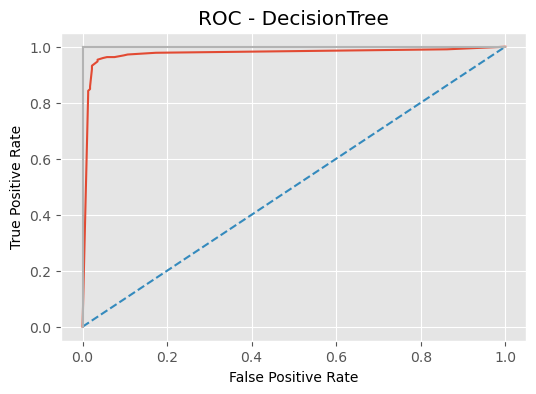

________________________________


,frame_count,length_w1,std_w1,length_w2,lag1_q50_w2,mfcc_kur_w2,sc_q75_w2,sc_skew_w2,stft_skew_w2,length_w3,length_w4,stft_std_w4,vocal_channel
0,0.106792,0.106787,0.098645,0.106809,0.730779,0.438077,0.540925,0.375576,0.267167,0.106787,0.106787,0.209656,speech
1,0.116504,0.116510,0.060536,0.116507,0.730779,0.457699,0.548850,0.319819,0.218665,0.116510,0.116486,0.235946,speech
2,0.097081,0.097088,0.049896,0.097085,0.730779,0.540126,0.650756,0.345141,0.205675,0.097088,0.097064,0.329336,speech
3,0.067960,0.067966,0.050156,0.067965,0.730779,0.590455,0.719119,0.316181,0.189831,0.067966,0.067942,0.301835,speech
4,0.174752,0.174753,0.055425,0.174749,0.730779,0.419206,0.521842,0.404533,0.291128,0.174753,0.174753,0.283187,speech


In [10]:
# Decide K ----> Number of best features to select
n = 12
selector = SelectKBest(k=n)
X_train_sel = selector.fit(X_train, y_train)
cols_idxs = selector.get_support(indices=True)
cols_idxs = np.append(cols_idxs,[-1])
df_UFS = df.iloc[:,cols_idxs]
X_train_sel = selector.transform(X_train)
print(df_UFS.shape)
df_UFS.head()
X_test_sel = selector.transform(X_test)

decision_tree = DecisionTreeClassifier()
param_grid = {
    'min_samples_leaf': [x for x in range(1,30)],
    'max_depth': [x for x in range(1,30)],
    'criterion':['gini','entropy']
}
grid_cv = GridSearchCV(decision_tree, param_grid, scoring="accuracy", n_jobs=-1, cv=5)
grid_cv.fit(X_train_sel, y_train)
print("Best Params", grid_cv.best_params_)
print("Best CV Score", grid_cv.best_score_)
print(f'Accuracy on Model 1 = {round(accuracy_score(y_test, grid_cv.predict(X_test_sel)), 10)}')

decision_tree = DecisionTreeClassifier(min_samples_leaf = grid_cv.best_params_['min_samples_leaf'], max_depth = grid_cv.best_params_['max_depth'], criterion=grid_cv.best_params_['criterion'])
decision_tree.fit(X_train_sel, y_train)
y_pred = decision_tree.predict(X_test_sel)

label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
y_score = decision_tree.predict_proba(X_test_sel)
fpr, tpr, _ = roc_curve(encoded_y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred, digits=3))
print('ROC Curve:', roc_auc)
plt.subplots(1, figsize=(6,4))
plt.title('ROC - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('________________________________')
df_UFS.head()

In [11]:
""" X_test_sel = selector.transform(X_test)

decision_tree = DecisionTreeClassifier(min_samples_leaf = grid_cv.best_params_['min_samples_leaf'], max_depth = grid_cv.best_params_['max_depth'], criterion=grid_cv.best_params_['criterion'])
decision_tree.fit(X_train_sel, y_train)
y_pred = decision_tree.predict(X_test_sel)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred, digits=3))
print('________________________________') """

" X_test_sel = selector.transform(X_test)\n\ndecision_tree = DecisionTreeClassifier(min_samples_leaf = grid_cv.best_params_['min_samples_leaf'], max_depth = grid_cv.best_params_['max_depth'], criterion=grid_cv.best_params_['criterion'])\ndecision_tree.fit(X_train_sel, y_train)\ny_pred = decision_tree.predict(X_test_sel)\nprint(f'Accuracy: {accuracy_score(y_test, y_pred)}' )\nprint(f'F1-score: {f1_score(y_test, y_pred, average=None)}')\nprint(classification_report(y_test, y_pred, digits=3))\nprint('________________________________') "

Testing for the selection of the 'best' DT hyperparameters

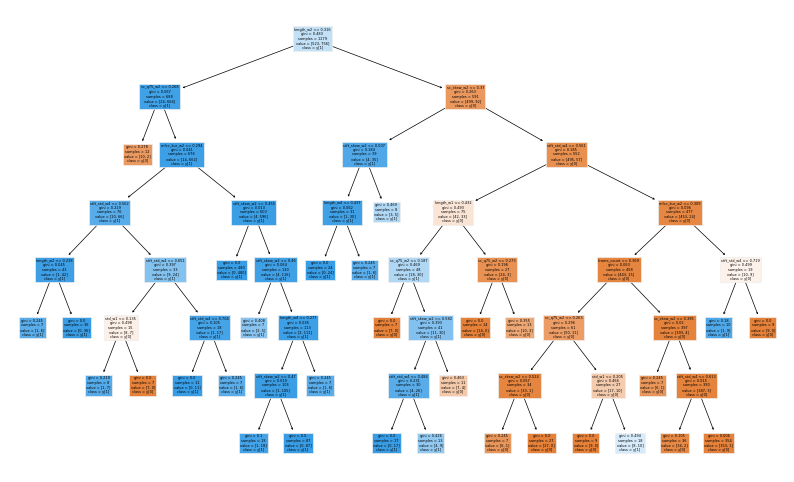

In [12]:
fig = plt.figure(figsize=(10,6))
_ = tree.plot_tree(decision_tree, 
                   feature_names=df_UFS.keys(),  
                   class_names=True,
                   filled=True)

### Select From Model algorithm

In [13]:
# decide maximum features to select
n = 11
selector = SelectFromModel(DecisionTreeClassifier(), max_features=n)
X_train_sel = selector.fit(X_train, y_train)
cols_idxs = selector.get_support(indices=True)
cols_idxs = np.append(cols_idxs,[-1])
df_SFM = df.iloc[:,cols_idxs]
#df_SFM.to_csv('data_SFM_best12.csv', index = False)
X_train_sel = selector.transform(X_train)
print(df_SFM.shape)
df_SFM.head()

(2452, 12)


,emotion_disgust,q25,sc_q25,stft_q25,length_w2,mfcc_kur_w2,sc_mean_w2,sc_min_w2,sc_kur_w2,q01_w3,stft_q25_w3,vocal_channel
0,0,0.875,0.560393,0.724380,0.106809,0.438077,0.405315,0.393472,0.087534,0.833258,0.667964,speech
1,0,0.875,0.561798,0.710610,0.116507,0.457699,0.420190,0.525674,0.051492,0.835891,0.637134,speech
2,0,1.000,0.472504,0.689968,0.097085,0.540126,0.474156,0.461177,0.060925,0.833487,0.652117,speech
3,0,0.875,0.537759,0.698599,0.067965,0.590455,0.556900,0.394148,0.052288,0.846461,0.736426,speech
4,0,0.875,0.505940,0.617679,0.174749,0.419206,0.404362,0.349367,0.130634,0.852914,0.609075,speech


Accuracy: 0.9508196721311475
F1-score: [0.94168467 0.95748031]
              precision    recall  f1-score   support

        song      0.916     0.969     0.942       225
      speech      0.977     0.938     0.957       324

    accuracy                          0.951       549
   macro avg      0.947     0.954     0.950       549
weighted avg      0.952     0.951     0.951       549

ROC Curve: 0.9834019204389575


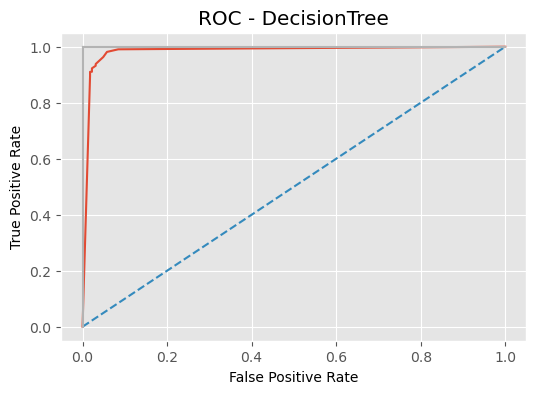

________________________________


In [14]:
X_test_sel = selector.transform(X_test)

decision_tree = DecisionTreeClassifier(min_samples_leaf=6) #random_state=78)
decision_tree.fit(X_train_sel, y_train)

y_pred = decision_tree.predict(X_test_sel)

label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
y_score = decision_tree.predict_proba(X_test_sel)
fpr, tpr, _ = roc_curve(encoded_y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred, digits=3))
print('ROC Curve:', roc_auc)
plt.subplots(1, figsize=(6,4))
plt.title('ROC - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('________________________________')

### Recursive Feature Elimination (RFE) algorithm

In [15]:
# decide number of features to select
n_features = [n for n in range(10,16)]
for i in n_features:
    selector = RFE(DecisionTreeClassifier(), n_features_to_select = i)
    X_train_sel = selector.fit(X_train, y_train)
    cols_idxs = selector.get_support(indices=True)
    cols_idxs = np.append(cols_idxs,[-1])
    df_RFE = df.iloc[:,cols_idxs]
    X_train_sel = selector.transform(X_train)
    print(df_RFE.shape)

    X_test_sel = selector.transform(X_test)

    decision_tree = DecisionTreeClassifier(min_samples_leaf=6) #random_state=78)
    decision_tree.fit(X_train_sel, y_train)

    y_pred = decision_tree.predict(X_test_sel)

    label_encoder = LabelEncoder()
    encoded_y_test = label_encoder.fit_transform(y_test)
    label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                            label_encoder.transform(label_encoder.classes_)))
    y_score = decision_tree.predict_proba(X_test_sel)
    fpr, tpr, _ = roc_curve(encoded_y_test, y_score[:,1])
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
    print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
    print(classification_report(y_test, y_pred, digits=3))
    print('ROC Curve:', roc_auc)
    plt.subplots(1, figsize=(6,4))
    plt.title('ROC - DecisionTree')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('________________________________')

KeyboardInterrupt: 

## Exporting datasets resulting from different FS algos

In [ ]:
#df_UFS.to_csv('dataFS_UFS.csv', index=False)
#df_SFM.to_csv('dataFS_SFM.csv', index=False)
#df_RFE.to_csv('data_RFE_best12.csv', index=False)

## Feature Projection (Dimensionality Reduction) for Classification

### Principal Component Analysis (PCA) algorithm
### visto che la PCA va utilizzata su dataset di grandi dimensionalità, utilizziamo sempre il dataset upToCubicTran [df Variable]





In [ ]:
pca = PCA(n_components=0.85) ##visto che l'obiettivo dell'utilizzo della PCA non è tanto la visualizzazione di variabili (che verrà fatta dopo con il T-SNE che è più adatto) indichiamo con n_components quanta varianza (85%, ma si può cambiare) vogliamo mantenere con le PC (il numero di PC è 
#dunque scelto dall'algoritmo, non fissato a priori )
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca.shape

(1279, 23)

Accuracy: 0.9089253187613844
F1-score: [0.89495798 0.91961415]
              precision    recall  f1-score   support

        song      0.849     0.947     0.895       225
      speech      0.960     0.883     0.920       324

    accuracy                          0.909       549
   macro avg      0.904     0.915     0.907       549
weighted avg      0.914     0.909     0.910       549

ROC Curve: 0.9450068587105623


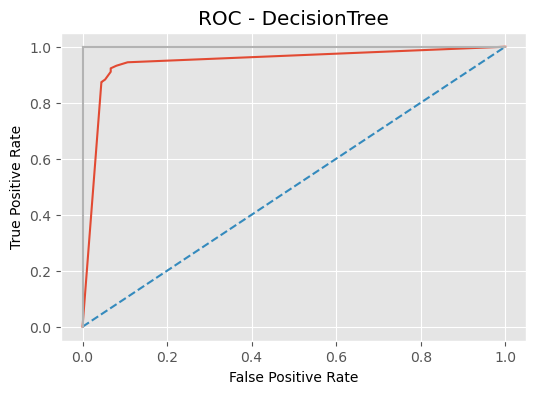

________________________________


In [ ]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

label_encoder = LabelEncoder()
encoded_y_test = label_encoder.fit_transform(y_test)
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
y_score = clf.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(encoded_y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}' )
print(f'F1-score: {f1_score(y_test, y_pred, average=None)}')
print(classification_report(y_test, y_pred, digits=3))
print('ROC Curve:', roc_auc)
plt.subplots(1, figsize=(6,4))
plt.title('ROC - DecisionTree')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print('________________________________')

Text(0, 0.5, 'Explained Variance Ratio')

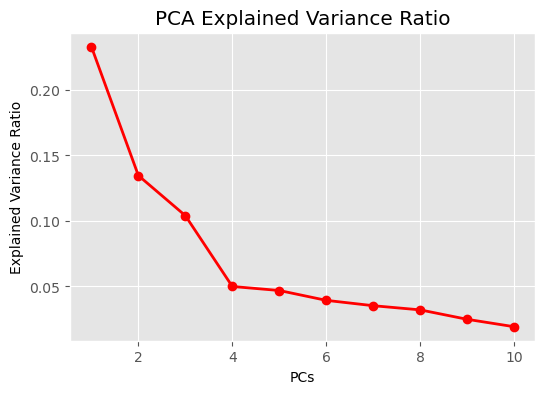

In [ ]:
plt.figure(figsize=(6, 4))
pc_n = 10
plt.plot((np.arange(pca.n_components_) + 1)[:pc_n], pca.explained_variance_ratio_[:pc_n], 'ro-', linewidth=2)
plt.title("PCA Explained Variance Ratio")
plt.xlabel("PCs")
plt.ylabel("Explained Variance Ratio")

In [ ]:
for x in range(10):
    print('PC{} Explained Variance Ratio: '.format(x+1), round(pca.explained_variance_ratio_[x]*100, 2), '%', sep='')

PC1 Explained Variance Ratio: 23.29%
PC2 Explained Variance Ratio: 13.46%
PC3 Explained Variance Ratio: 10.4%
PC4 Explained Variance Ratio: 5.0%
PC5 Explained Variance Ratio: 4.69%
PC6 Explained Variance Ratio: 3.94%
PC7 Explained Variance Ratio: 3.53%
PC8 Explained Variance Ratio: 3.21%
PC9 Explained Variance Ratio: 2.49%
PC10 Explained Variance Ratio: 1.93%


### Random Subspace Projection (RSP) algorithm

## Multi Dimensional Feature Scaling (MDS) for Visualization

### IsoMap

### t-SNE

In [ ]:
tsne = TSNE(n_components=2) ##qua l'obiettivo è visualizzare, quindi solo due variabili 
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne.shape 
print(y_train)
y_train_color=y_train.copy()
for i in range(len(y_train_color)):##devo fare sto troiao perchè per plottare vuole in input un array con 0 o 1... capiamo poi se conviene fare questa operazione a livello di dataset
    if y_train_color[i]=='speech':
        y_train_color[i]=0
    else:
        y_train_color[i]=1
print(y_train_color)


['speech' 'speech' 'speech' ... 'speech' 'speech' 'speech']
[0 0 0 ... 0 0 0]


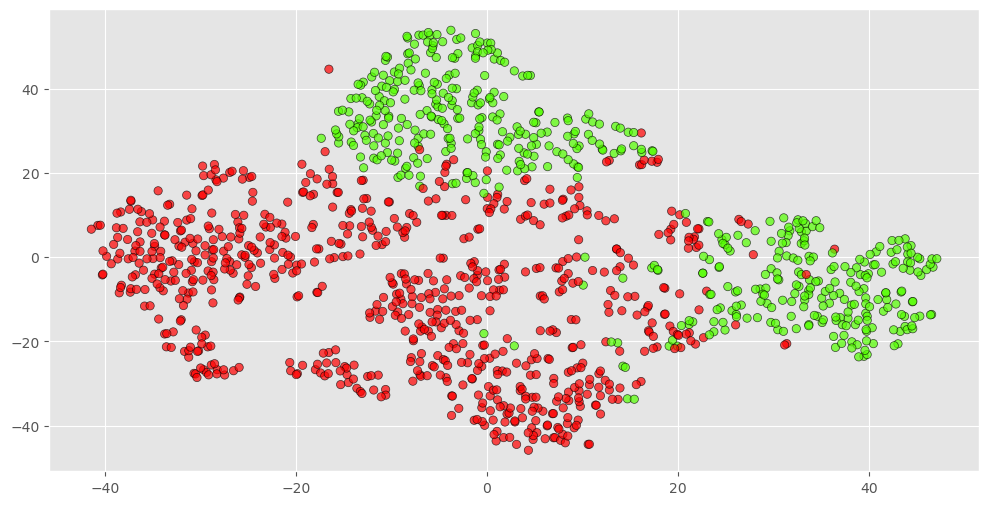

In [ ]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_color, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_tsne, y_train)

y_pred = clf.predict(X_train_tsne)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))

Accuracy 0.982017200938233
F1-score [0.97811608 0.98473789]
              precision    recall  f1-score   support

        song       0.97      0.98      0.98       523
      speech       0.99      0.98      0.98       756

    accuracy                           0.98      1279
   macro avg       0.98      0.98      0.98      1279
weighted avg       0.98      0.98      0.98      1279

